
# Introduction (Kevin)

Ici on explique que faire la compétition en P3A ça a servi de pretexte pour se confronter à différents aspect du machine learning et de s'intérroger sur les aspects pratiques et théoriques de certaines méthodes.

During our projet 3A, we participed in a kaggle competition named blabla.

# Data exploration and analysis

Un petit blabla d'introduction


## Features distributions (Skander)

On etudie les distributions, le mieux étant d'avoir quelque chose de centré, symetrique...
Détailler l'utilisation de la fonction skew de scipy.stat pour déterminé sur qui appliquer le log.
Détaillé aussi les formules qui explique pourquoi le log.

In [1]:
from __future__ import division, print_function
import os
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
try :
    import seaborn as sns; sns.set()
except ImportError:
    print("seaborn not found on your computer. "
          "Install it if you want pretty charts \n"
          "If you have internet access you can run in a cell : \n"
          "!pip install -U seaborn ")

pd.set_option('display.max_columns', None)
%matplotlib inline


In [2]:
train = pd.read_csv("train.csv",index_col = 0)
train.loc[train['PoolQC'].isnull(),'PoolQC'] = 'N.a'
train.loc[train['Fence'].isnull(),'Fence'] = 'N.a'
train.loc[train['MiscFeature'].isnull(),'MiscFeature'] = 'N.a'
train.loc[train['GarageCond'].isnull(),'GarageCond'] = 'N.a'
train.loc[train['GarageQual'].isnull(),'GarageQual'] = 'N.a'
train.loc[train['GarageFinish'].isnull(),'GarageFinish'] = 'N.a'
train.loc[train['GarageType'].isnull(),'GarageType'] = 'N.a'
train.loc[train['FireplaceQu'].isnull(),'FireplaceQu'] = 'N.a'
train.loc[train['BsmtFinType2'].isnull(),'BsmtFinType2'] = 'N.a'
train.loc[train['BsmtFinType1'].isnull(),'BsmtFinType1'] = 'N.a'
train.loc[train['BsmtExposure'].isnull(),'BsmtExposure'] = 'N.a'
train.loc[train['BsmtCond'].isnull(),'BsmtCond'] = 'N.a'
train.loc[train['BsmtQual'].isnull(),'BsmtQual'] = 'N.a'
train.loc[train['Alley'].isnull(),'Alley'] = 'N.a'

y_tr = train['SalePrice']
X_tr = train.drop('SalePrice',axis = 1)


Let's look at the distribution of the differents features.

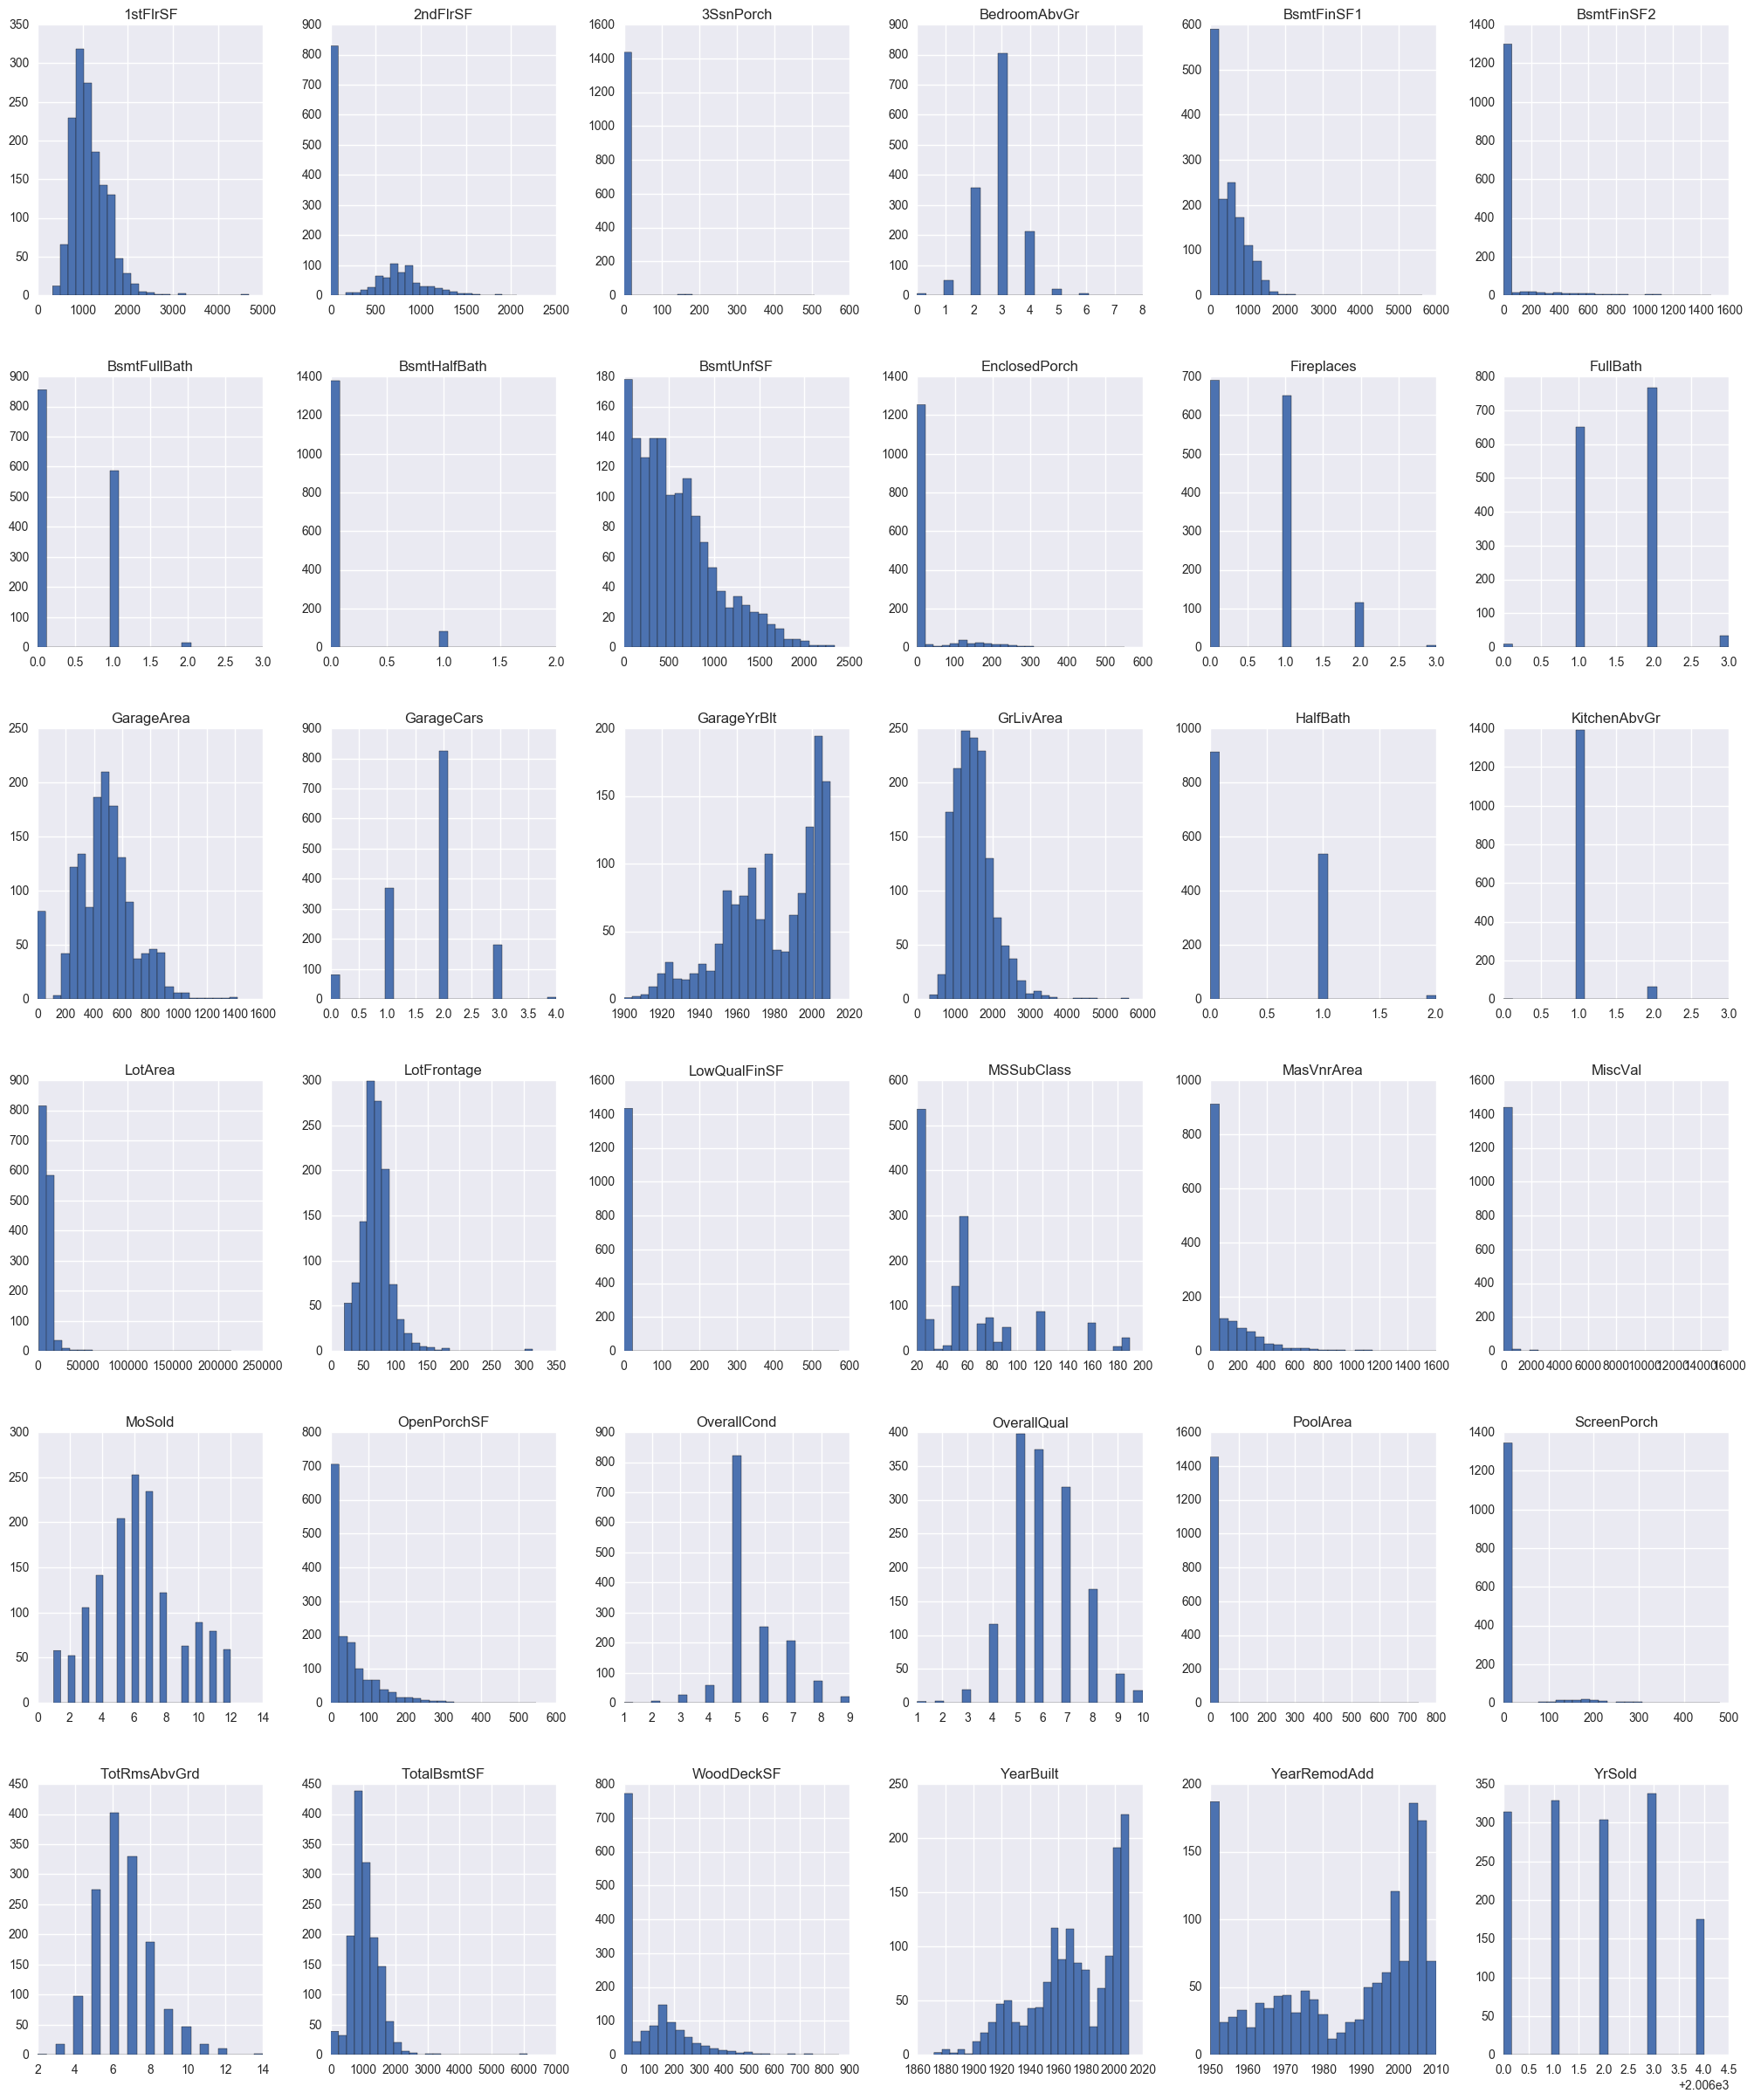

In [111]:
X_tr.hist(figsize=(25, 30), bins=25);

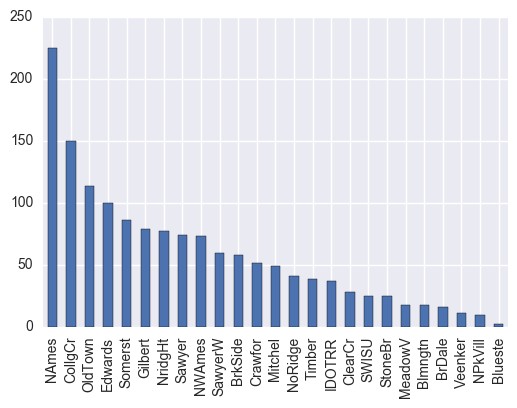

In [3]:
X_tr.Neighborhood.value_counts().plot(kind='bar');

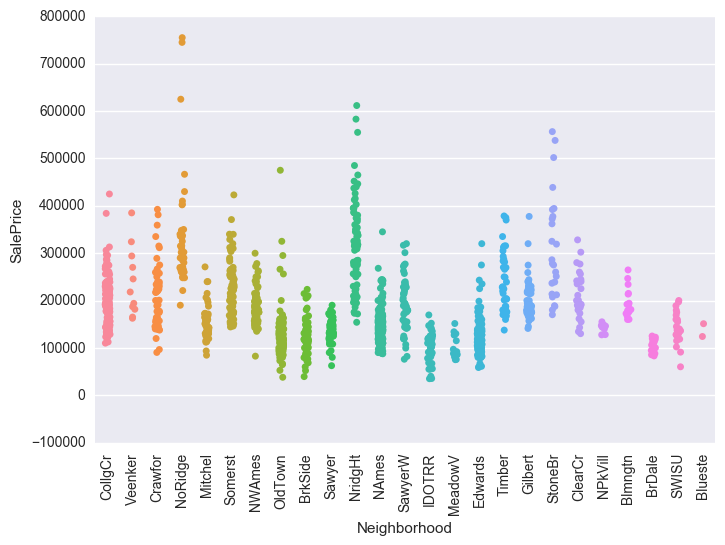

In [3]:
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)
sns.stripplot(x="Neighborhood", y="SalePrice",\
              data=train.loc[:,['Neighborhood','SalePrice']],\
              jitter = True)
plt.xticks(rotation=90);

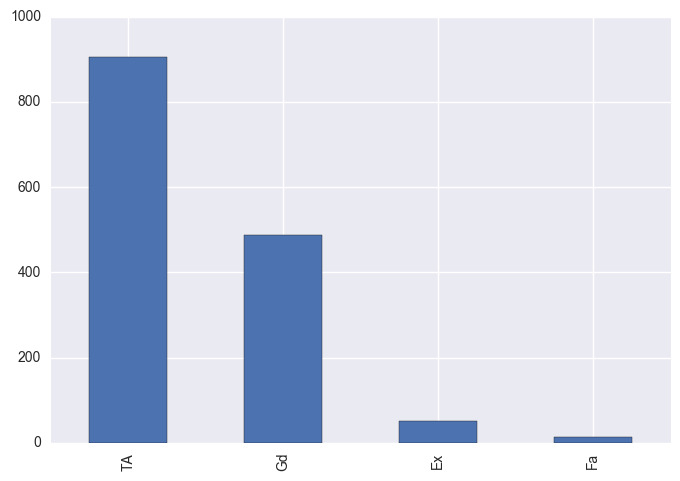

In [4]:
X_tr.ExterQual.value_counts().plot(kind='bar');

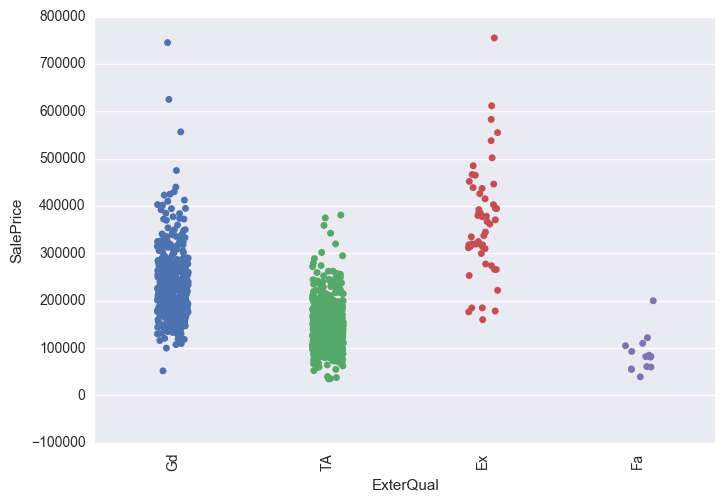

In [5]:
sns.set(style="darkgrid", color_codes=True)
sns.stripplot(x="ExterQual", y="SalePrice",\
              data=train.loc[:,['ExterQual','SalePrice']],\
              jitter = True)
plt.xticks(rotation=90);

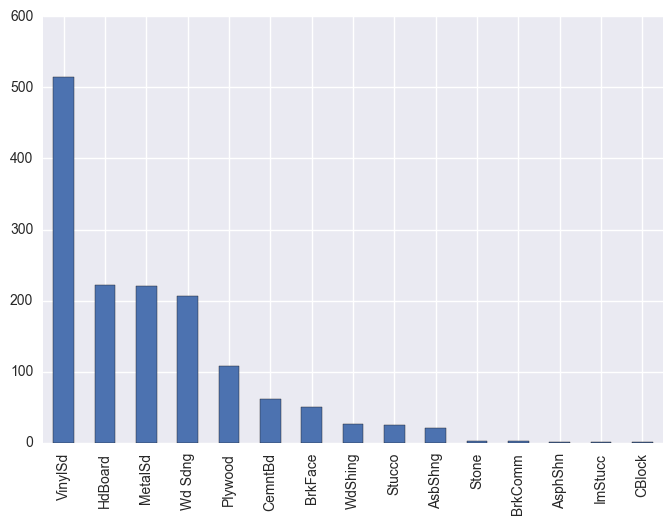

In [6]:
X_tr.Exterior1st.value_counts().plot(kind='bar');

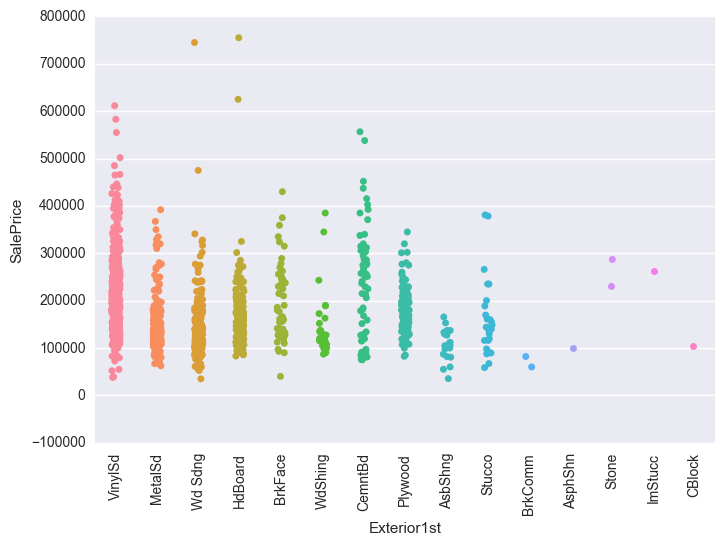

In [7]:
sns.set(style="darkgrid", color_codes=True)
sns.stripplot(x="Exterior1st", y="SalePrice", \
              data=train.loc[:,['Exterior1st','SalePrice']],\
              jitter = True)
plt.xticks(rotation=90);

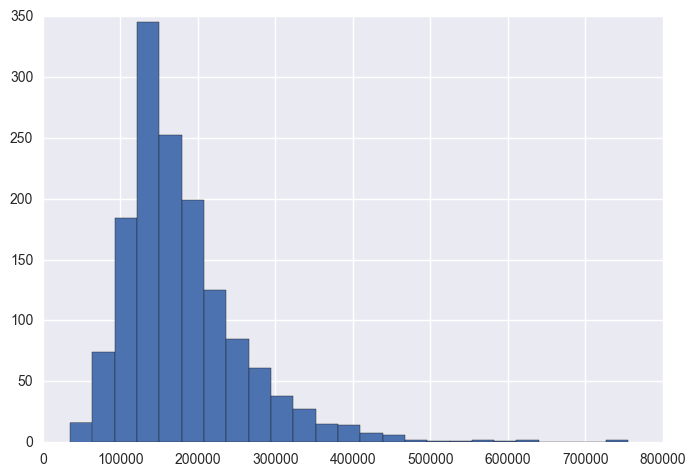

In [8]:
y_tr.hist(bins = 25);

In [9]:
y_tr = np.log(y_tr)

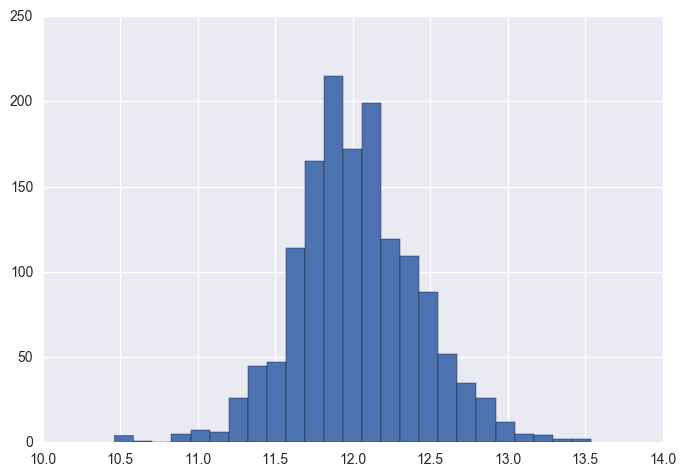

In [10]:
y_tr.hist(bins = 25);

## Features importance (Mathieu)


Once we have explored the data, we can interest ourselves in the features importance.

Due to the concrete aspect of the challenge, we could think ; without using any algorithm ; about which features is important or not and how much.

However there are many features, and it's difficult to see if the size of the garage is more important than the quality of the exterior. Thus we are going to apply algorithms to our data in order to get an idea of the features importance.

The first thing we could think of would be to fit a linear regression on our data and look at the coefficient of the regression to see which features counts and which doesn't. To do that we have to assure that the data are normalised, indeed if it is not the case features with high values as the lot area would have very small coefficient in comparison to features as the overall quality which only takes values between 1 and 10. 

Here we'll scale the data to have values between 0 and 1. Also we'll use Lasso linear regression instead of a classical linear regression because we've got a lot of features and Lasso helps us to pick the most interesting ones (Lasso procedure will be detailled in the fourth part of this report).

0.131683876947


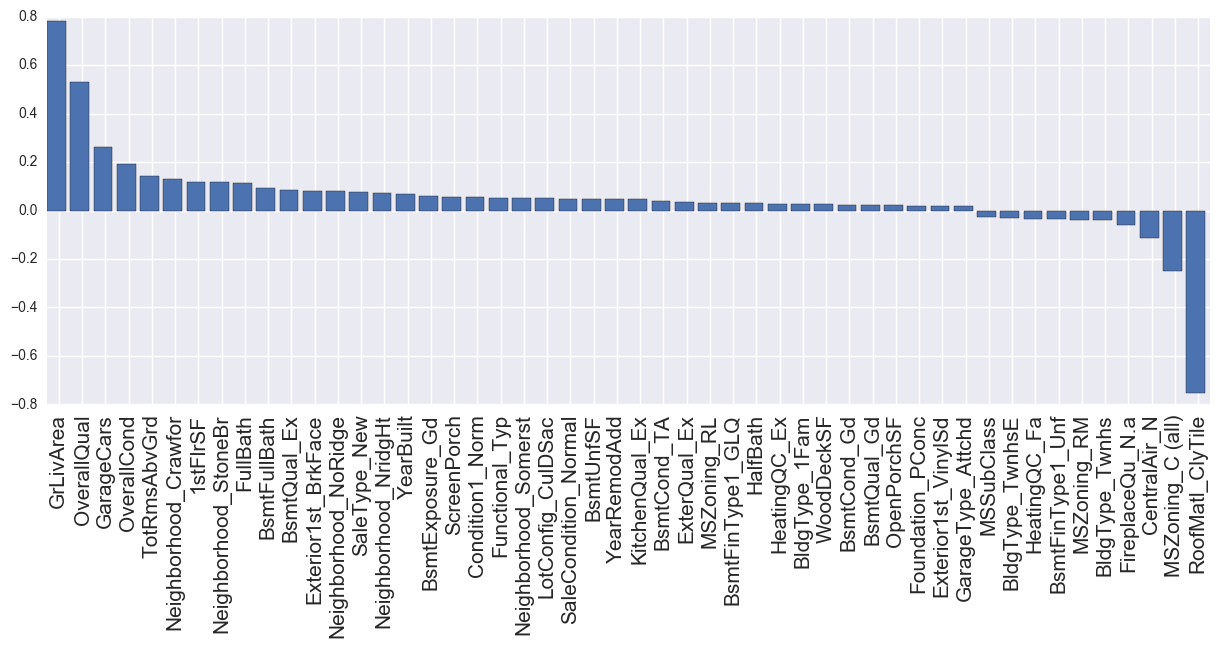

In [11]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt


X_df = pd.get_dummies(X_tr)

X_df.fillna(X_df.mean(),inplace = True)
plt.figure(figsize=(15, 5))


X = MinMaxScaler().fit_transform(X_df)
y = y_tr.values
skf = KFold(n_splits = 2,shuffle = True,random_state = 7)

valid_train_is, valid_test_is = list(skf.split(X, y))[0]

X_valid_train = X[valid_train_is]
y_valid_train = y[valid_train_is]
X_valid_test = X[valid_test_is]
y_valid_test = y[valid_test_is]


reg = Lasso(0.001)
reg.fit(X_valid_train, y_valid_train)

print(sqrt(mean_squared_error(y_valid_test,reg.predict(X_valid_test))))

l = np.concatenate([np.arange(0,40),np.arange(292,302)])
ordering = np.argsort(reg.coef_)[::-1][l]

importances = reg.coef_[ordering]

feature_names = X_df.columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

We have drawn the values of the 40 higher positive coefficients and the values of the 10 higher negative coefficients. From this plot, we can interpret that features as GrLivArea, OverallQual, GarageCars  make the price increase when they increase, and that features like "RoofMatl is ClyTile" or "no Central Air" make the price decrease.

We can use other algorithms to try to understand the features importance in this problem. For instance we are going to apply a random forest algorithm to our data in order to get an idea of what features matter the most.  However, unlike the linear model, we don't get directly a quantity which allows us to compare the features.

On way to obtain a quantity that could describe the features importance using random forest regression would be the following :

- for each tree in the forest :
the importance associated with the features f would be the mean of the error reduction for each node involving f, weighted by the number of sample coming to that node. Where the error reduction of a node would be the sum of the errors of prediction for the node's incoming samples minus the sum of the errors of prediction after the node's split.
Here we are working with the mean squared error.

- the quantity obtained for one tree would be averaged for all the tree in the forest

This quantity describe the importance of a feature linked to its power to decrease the training error. In other words, a feature is important if  splitting according to this feature allows to reduce a lot the internal error.

In sklearn we have access to the feature importances through the feature_importances attribute of the RandomForestRegressor class.

0.145467203695


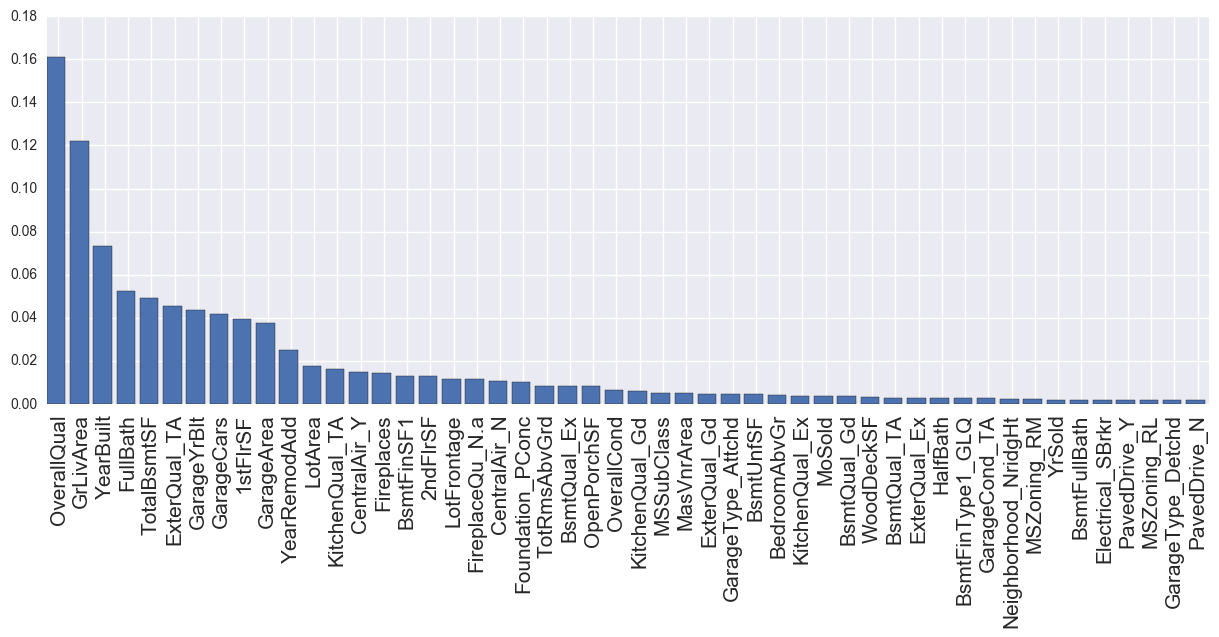

In [12]:
from sklearn.ensemble import RandomForestRegressor


X_df = pd.get_dummies(X_tr)
X_df.fillna(X_df.mean(),inplace = True)

plt.figure(figsize=(15, 5))

X = X_df.values
y = y_tr.values
skf = KFold(n_splits = 2,shuffle = True,random_state = 7)

valid_train_is, valid_test_is = list(skf.split(X, y))[0]

X_valid_train = X[valid_train_is]
y_valid_train = y[valid_train_is]
X_valid_test = X[valid_test_is]
y_valid_test = y[valid_test_is]


reg = RandomForestRegressor(n_estimators = 300,max_features = 0.2,\
                            max_depth = 12,min_samples_leaf = 2)
reg.fit(X_valid_train, y_valid_train)

print(sqrt(mean_squared_error(y_valid_test,reg.predict(X_valid_test))))

ordering = np.argsort(reg.feature_importances_)[::-1][:50]

importances = reg.feature_importances_[ordering]
feature_names = X_df.columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

Here we printed the 50 most important features according to the random forest algorithm. We see that the top features are slightly different from those obtain through linear regression, however features as OverallQual, GarageSize or GrLivArea are still in top position, so we are confident they are really important features for our regression problem.

# Data preprocessing

blabla

## Symetrize distributions (Skander)

À voir comment partager entre ici et le 2.1 


## Missing values (Kevin)

Petite partie, il y en a pas beaucoup (à vérifier)
on fait simplement remplacement par la moyenne, et pas le plus courrant.
(peut être discuter de l'interet de prendre la moyenne et le plus courant sur test + train ensemble ou en séparé.

## Dealing with cathegorical features (Skander)


Ici on peut parler des différentes approches, on a choisit get_dummies mais comparer
parler du problème du drop_first ou non, alternative : ajouter la moyenne par quartier blabla

Détailler le code.

## Features engineering (Kevin)

Les features qu'on a essayé d'ajouter, le pourquoi.
peut être parler de la binarisation des variables continues

# Prices predictions

blabla

## Evaluation of our model performances (Mathieu)

In Kaggle type competition, we have to predict values on a test set that we don't know the labels.
Due to the classical Bias-Variance trade-off we can't content ourselves to minimise the training error, and in particular the bias, which conducts irremediably to over-fitting.

To test the predictive power of our algorithms we have to split our train set into train/test sets in order to have a labelled test set. 
We use the K-folds method to obtain an estimation of our testing error.
Indeed we split our train set into K sets, and test our algorithm on each of this K sets after training it on the four others. We obtained K training errors that we can average.
Here we doesn't have any order between the samples, so we can split randomly to obtain the K sets.

In the literature K is often choose as 5 or 10, here we prefer choosing 5 folds because we don't have a large amount of train samples. 

We can use this computed test error to compare our different algorithms and in particular to choose the different hyper-parameters of our models.

We preferred recoding a cross validation function using K-fold so we could also deal with the preprocessing in the process. Indeed preprocessing should be done for each set of the split separately, especially when we use features as the mean of prices for each neighbourhoods (means should be calculated using only the train set because in the other case we use information of the test labels in our features, which leads to under estimation of the cross validation error).

In [38]:
from sklearn.model_selection import KFold
from preprocess import Preprocess


def RMSE(y,y_pred):
    return(np.sqrt(sum((y-y_pred)**2)/len(y)))

def crossVal(model,X,y,cv = 5):
    Kfold = KFold(n_splits=cv,shuffle=True,random_state=7)
    prep = Preprocess()
    res = []
    tr_error = []
    for train,test in  Kfold.split(X,y):
        X_train, X_test, y_train, y_test = X.iloc[train,:],X.iloc[test,:],y.iloc[train],y.iloc[test]
        prep.fit(X_train,y_train)
        X_train = prep.transform(X_train)
        X_test = prep.transform(X_test,test =True)
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        res.append(RMSE(y_test,y_pred))
        tr_error.append(RMSE(y_train,model.predict(X_train)))
    return np.mean(res),np.mean(tr_error)

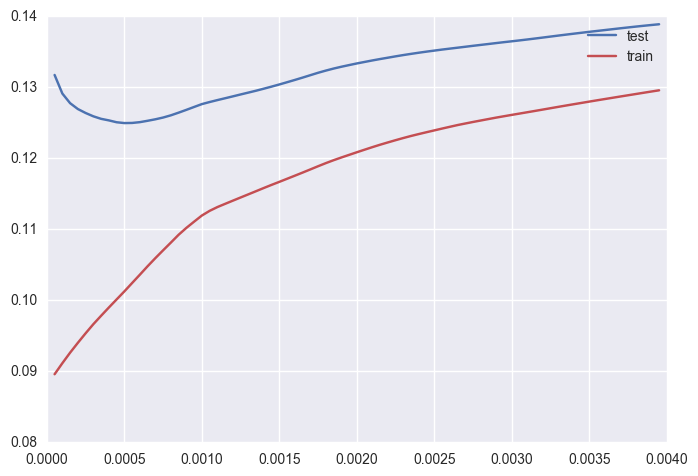

In [23]:

def plot_errorL(l):
    res = []
    trai = []
    for alpha in l:
        tst,tr = crossVal(Lasso(alpha=alpha),X_df,y_tr)
        res.append(tst)
        trai.append(tr)
    plt.plot(l,res,label ='test')
    plt.plot(l,trai,label ='train',color = 'r')
    plt.legend()
    plt.show()

    
plot_errorL(np.arange(0.00005,0.004,0.00005))



Here we see that test and train errors don't behave the same way, training error increase with the penalisation, whereas test error have a minimum for a $\lambda \ne 0$.

When there are many parameter to optimize, drawing curves is not more a option. We used the library $\textit{pysmac}$ and in particular the $\textit{fmin}$ function from the $\textit{optimize}$ module.
It performs a random search in a delimited domain for our hyper-parameters.

In [39]:
from pysmac.optimize import fmin

def objective_function(x_int):
    objective_function.n_iterations += 1
    n_estimators,max_depth,max_features =x_int
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    max_features = int(max_features)
    reg = RandomForestRegressor(n_estimators=n_estimators,\
                                max_depth=max_depth,\
                                max_features = max_features/10.0)
    score,tr = crossVal(reg, X_df, y_tr)
    print (objective_function.n_iterations, \
        ": n_estimators = ", n_estimators, \
        "\t max_depth = ", max_depth,\
        "\t max_features = ", max_features/10.0, \
        "rmse = ", score)
    return score

In [46]:
objective_function.n_iterations = 0
xmin, fval = fmin(objective_function,\
                  x0_int=(10,5,2), xmin_int=(10,5,2), xmax_int=(100,20,10),\
                  max_evaluations=10)

1 : n_estimators =  10 	 max_depth =  5 	 max_features =  0.2 rmse =  0.169013087924
Number of evaluations 1, current fmin: 0.169013
2 : n_estimators =  17 	 max_depth =  15 	 max_features =  0.8 rmse =  0.147652132335
Number of evaluations 2, current fmin: 0.147652
3 : n_estimators =  71 	 max_depth =  8 	 max_features =  0.4 rmse =  0.143537636219
Number of evaluations 3, current fmin: 0.143538
4 : n_estimators =  19 	 max_depth =  11 	 max_features =  0.7 rmse =  0.144628472692
5 : n_estimators =  91 	 max_depth =  8 	 max_features =  0.7 rmse =  0.145226421551
6 : n_estimators =  100 	 max_depth =  10 	 max_features =  1.0 rmse =  0.144818531607
7 : n_estimators =  54 	 max_depth =  7 	 max_features =  0.5 rmse =  0.147431837734
8 : n_estimators =  65 	 max_depth =  6 	 max_features =  0.3 rmse =  0.15184922654
9 : n_estimators =  97 	 max_depth =  14 	 max_features =  0.2 rmse =  0.13976466884
Number of evaluations 9, current fmin: 0.139765
10 : n_estimators =  38 	 max_depth =  1

## Linear models (Kevin)

parler de lasso, de ridge de elastic net, balancer toute la théorie qu'on a dessus vu en stats et en ML2.
Parler de Adaptative Lasso.

## Random Forests (Skander)

parler de random forests, la théorie, mettre le truc de kegl derrière

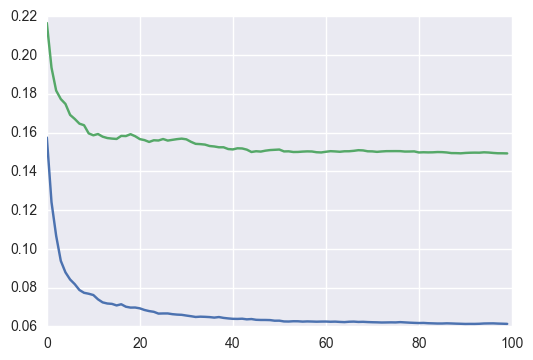

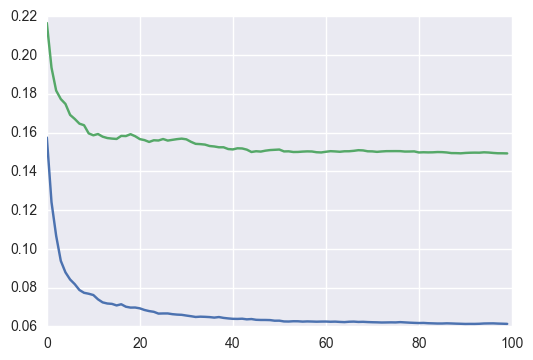

In [9]:
import pylab as pyl
from time import sleep
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from IPython import display
from math import sqrt

X = pd.get_dummies(X_tr)
X.fillna(X.mean(),inplace = True)

X=X.values
Y = y_tr.values 

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=61)



max_depth = 12 # tree depth
n_trees = 100 # number of trees
max_features = 30 # number of random features at each cut
n_samples = X_train.shape[0]

ts = pyl.arange(n_trees)
training_errors = []
test_errors = []
y_pred_train = np.zeros(len(y_train))
y_pred_test = np.zeros(len(y_test))

for t in range(n_trees):
    # Your code should go here
    train = np.random.choice(range(X_train.shape[0]),X_train.shape[0])
    clf = DecisionTreeRegressor(max_features = max_features,\
                                max_depth = max_depth)
    clf.fit(X_train[train,:],y_train[train])
    pyl.clf()
    y_pred_train = (y_pred_train*t + clf.predict(X_train))/(t+1)
    y_pred_test = (y_pred_test*t + clf.predict(X_test))/(t+1)
    training_error = sqrt(mean_squared_error(y_pred_train,y_train))
    test_error = sqrt(mean_squared_error(y_pred_test,y_test))
    training_errors.append(training_error)
    test_errors.append(test_error)
    pyl.plot(ts[:t+1], training_errors[:t+1])
    pyl.plot(ts[:t+1], test_errors[:t+1])
    display.clear_output(wait=True)
    display.display(plt.gcf())
    sleep(.001)

In [5]:
y_pred_test

array([ 150470.47372549,  265308.38818182,  145855.2929198 ,
        127909.38278481,  183410.75166667,  198329.54222222,
        136196.95770287,  110090.50843226,  388536.12      ,
         99872.80103175,  148613.73963981,  162390.27      ,
        192860.86547619,  130634.97640239,  146631.30833333,
        287725.30571429,  139838.80333333,  146871.92463458,
        265462.01      ,  137336.09      ,  120002.875     ,
        199313.075     ,  123910.18      ,  322461.14      ,
        171790.62272727,  129175.83384793,  168234.02380952,
        121814.93321609,   94080.47971429,  270067.175     ,
        136019.82847222,  120194.56071429,  168190.66851852,
        165595.18831169,  169156.02      ,  171330.74351852,
        141251.12255905,  128669.28642824,  193647.55284819,
        157769.225     ,  218638.01      ,  124855.124     ,
        155439.44007937,  137578.76315789,  203424.18      ,
        250294.5       ,  166347.54230769,   95713.07908213,
        185571.93050505,

## Boosting methods (Mathieu)

faire pareil qu'en haut avec adaboost (à voir car semble dur en fait)
expliquer théorie derrière gradient boosting


In [13]:
import numpy as np
x = np.array([[1,3],[2,2]])
y = np.array([1,2])
np.dot(x.T,y)

array([5, 7])

## Combining our models (Mathieu)

expliquer les méthodes pour combiner les algos